<a href="https://colab.research.google.com/github/ivllnv/CPE313-Final-Project/blob/main/Notebooks/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import requests
import warnings
warnings.filterwarnings('ignore')
import csv, json
import re
import folium
import geopandas as gpd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Natural Language Processing

## Topic Modeling

### Libraries

In [30]:
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import gensim
from gensim.models import LsiModel
from gensim.models.ldamodel import LdaModel
from gensim.models import TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from spacy.tokens import Token
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [12]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Preprocess

In [13]:
file_path1 = '/content/drive/Shareddrives/CPE313/Yelp_AcademicDataset/yelp_academic_dataset_business.json'
file_path2 = '/content/drive/Shareddrives/CPE313/Yelp_AcademicDataset/sentiment_dataset.csv'

In [14]:
def read_json_lines(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return data

In [15]:
business_json = read_json_lines(file_path1)
business_df = pd.DataFrame(business_json)
review_csv = pd.read_csv(file_path2)

In [16]:
business_json = business_df[['business_id', 'name', 'latitude', 'longitude']]
merge = pd.merge(review_csv, business_json, on='business_id', how='left')
df = merge[['business_id', 'name', 'latitude', 'longitude', 'stars', 'date', 'text','cleanText', 'sentiment']]

In [17]:
df.isna().sum()

business_id        0
name           11492
latitude       11492
longitude      11492
stars              0
date               0
text               0
cleanText          1
sentiment          0
dtype: int64

In [18]:
df = df.dropna()

In [19]:
df.shape

(88507, 9)

In [20]:
df.head(2)

,business_id,name,latitude,longitude,stars,date,text,cleanText,sentiment
0,XQfwVwDr-v0ZS3_CbbE5Xw,Turning Point of North Wales,40.210196,-75.223639,3,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is...",decide eat aware going take hours beginning en...,positive
1,7ATYjTIgM3jUlt4UM3IypQ,Body Cycle Spinning Studio,39.952103,-75.172753,5,2012-01-03 15:28:18,I've taken a lot of spin classes over the year...,taken lot spin classes years nothing compares ...,positive


In [21]:
value_counts = df['business_id'].value_counts()
value_counts

business_id
GBTPC53ZrG1ZBY3DT8Mbcw    950
PY9GRfzr4nTZeINf346QOw    460
W4ZEKkva9HpAdZG88juwyQ    433
vN6v8m4DO45Z4pp8yxxF_w    404
pSmOH4a3HNNpYM82J5ycLA    384
                         ... 
1qHkyWDixBqIE_SH4fuCXQ      1
4KJc9uwoe7WUTS5QoxEZLg      1
WM5oG8uHlAnjcSvl-HArrQ      1
rhTZnurJL8FXjbK6kKbOSA      1
npyH-DyEMLhDMIqEedmB-g      1
Name: count, Length: 8777, dtype: int64

In [22]:
#Sample
print(df[['cleanText', 'sentiment']].iloc[27])

cleanText    great staff always helps always nice always cl...
sentiment                                             positive
Name: 32, dtype: object


In [23]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [24]:
def preprocess_lemmatize(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  """
  Preprocesses and lemmatizes text.

  Args:
      text: The text to preprocess and lemmatize.
      allowed_postags: A list of allowed part-of-speech tags (default: NOUN, ADJ, VERB, ADV).

  Returns:
      A list of lemmatized tokens.
  """

  # Tokenize the text
  tokens = word_tokenize(text.lower())

  # Create a spaCy Doc object from the tokens
  doc = nlp(" ".join(tokens))

  # Filter and lemmatize with spaCy
  lemmas = [token.lemma_ for token in doc if token.pos_ in allowed_postags and isinstance(token, Token)]

  return lemmas


In [25]:
df['processed_text'] = df['cleanText'].apply(preprocess_lemmatize)

In [26]:
#Sample again
print(df[['processed_text', 'sentiment']].iloc[27])

processed_text    [great, staff, always, help, always, nice, alw...
sentiment                                                  positive
Name: 32, dtype: object


In [27]:
id2word = corpora.Dictionary(df['processed_text'])
texts = df['processed_text']
corpus = [id2word.doc2bow(text) for text in texts]

In [28]:
# Use TF-IDF
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [29]:
import matplotlib.pyplot as plt

def plot_coherence(coherence_values, start, limit, step, title):
  x = range(start, limit, step)
  plt.plot(x, coherence_values)
  plt.title(title)
  plt.xlabel("Number of Topics")
  plt.ylabel("Coherence")
  plt.legend(("Coherence"), loc='best')
  plt.show()

### Latent Dirichlet Allocation (LDA)

In [ ]:
def calc_coherence_LDA(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    highest_coherence = 0
    best_num_topics = None

    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics, alpha=.1, eta=0.1, random_state=42)
        model_list.append(model)
        print('Model Created')
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherencemodel.get_coherence()
        print(coherence)
        coherence_values.append(coherence)
        if coherence > highest_coherence:
          highest_coherence = coherence
          best_num_topics = num_topics

    return model_list, coherence_values_lda, best_num_topics

In [ ]:
model_list, coherence_values_lda, best_num_topics = calc_coherence_LDA(dictionary=id2word,
                                                                       corpus=corpus_tfidf,
                                                                       texts=texts,
                                                                       start=20,
                                                                       limit=50,
                                                                       step=2)

Model Created
0.5342435062052877
Model Created
0.5512599544942673
Model Created
0.5778022637313022
Model Created
0.5833080864387905
Model Created
0.582643899862134
Model Created
0.5676281746806027
Model Created
0.5700561247005823
Model Created
0.5741346046248677
Model Created
0.5930668432283352
Model Created
0.5960040468715659
Model Created
0.5909857951291178
Model Created
0.5970904018174197
Model Created
0.5731843353290103
Model Created
0.6047930813202336
Model Created
0.6045519619428577


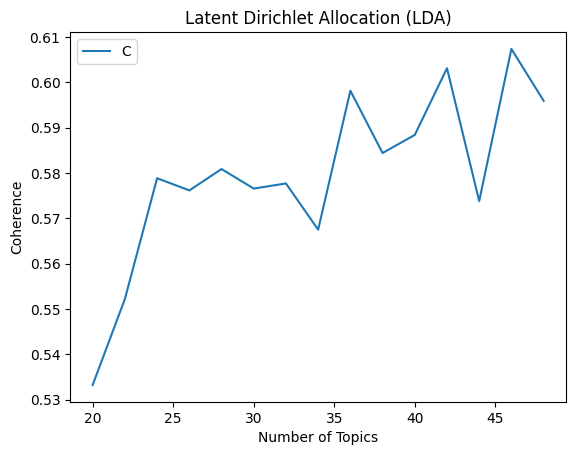

In [ ]:
plot_coherence(coherence_values_lda,
               start=20,
               limit=50,
               step=2,
               title="Latent Dirichlet Allocation (LDA)")

In [ ]:
print("Number of topics with highest coherence:", best_num_topics)

Number of topics with highest coherence: 46


In [ ]:
index = coherence_values_lda.index(max(coherence_values_lda))
model_list[index].show_topics()

[(27,
  '0.008*"apartment" + 0.006*"sticker" + 0.005*"disgust" + 0.005*"lease" + 0.004*"cram" + 0.004*"telling" + 0.004*"secure" + 0.003*"remarkable" + 0.003*"vip" + 0.003*"jewish"'),
 (25,
  '0.009*"beg" + 0.007*"deliciousness" + 0.004*"facebook" + 0.004*"suburban" + 0.004*"dusty" + 0.004*"uptown" + 0.004*"fil" + 0.003*"significant" + 0.003*"gyoza" + 0.003*"military"'),
 (40,
  '0.016*"chipotle" + 0.011*"beignet" + 0.010*"hamburger" + 0.009*"louis" + 0.007*"college" + 0.007*"meatball" + 0.007*"court" + 0.006*"spaghetti" + 0.005*"tri" + 0.005*"involve"'),
 (29,
  '0.009*"gator" + 0.008*"closed" + 0.008*"branch" + 0.007*"curd" + 0.006*"excessive" + 0.006*"stew" + 0.005*"grub" + 0.005*"blah" + 0.004*"beloved" + 0.004*"skilled"'),
 (28,
  '0.008*"remedy" + 0.007*"trail" + 0.007*"aesthetic" + 0.005*"hike" + 0.005*"barbeque" + 0.005*"breath" + 0.004*"lackluster" + 0.004*"sublime" + 0.004*"serene" + 0.004*"edible"'),
 (20,
  '0.009*"ill" + 0.009*"huevos" + 0.008*"hoagie" + 0.007*"alot" + 0.0

### Latent Semantic Analysis (LSA)


In [ ]:
def calc_coherence_LSI(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    highest_coherence = 0
    best_num_topics = None

    for num_topics in range(start, limit, step):
        model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        print('Model Created')
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherencemodel.get_coherence()
        print(coherence)
        coherence_values.append(coherence)
        if coherence > highest_coherence:
          highest_coherence = coherence
          best_num_topics = num_topics

    return model_list, coherence_values_Lsi, best_num_topics

In [ ]:
model_list, coherence_values_Lsi, best_num_topics = calc_coherence_LSI(dictionary=id2word,
                                                                       corpus=corpus_tfidf,
                                                                       texts=texts,
                                                                       start=20,
                                                                       limit=50,
                                                                       step=2)

Model Created
0.3802894248249841
Model Created
0.3773341467838712
Model Created
0.3652365069961678
Model Created
0.36972221304139635
Model Created
0.3605010219372592
Model Created
0.35314978261973357
Model Created
0.3490763514268493
Model Created
0.3477018744438066
Model Created
0.34987925258153557
Model Created
0.34285167642535574
Model Created
0.33956132812409756
Model Created
0.3344892930040374
Model Created
0.3323228187422129
Model Created
0.3318355891341303
Model Created
0.3350557758820452


In [ ]:
print("Number of topics with highest coherence:", best_num_topics)

Number of topics with highest coherence: 20


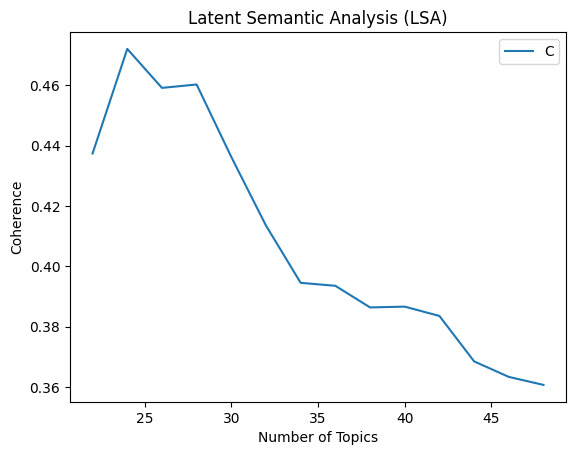

In [ ]:
plot_coherence(coherence_values_Lsi,
               start=22,
               limit=50,
               step=2,
               title="Latent Semantic Analysis (LSA)")


In [ ]:
index = coherence_values_Lsi.index(max(coherence_values_Lsi))
model_list[index].show_topics()

### Non Negative Matrix Factorization (NMF)

In [39]:
def nmf_topic_modeling(documents, num_topics=5, num_top_words=10):
    # Apply NMF
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_model.fit(tfidf)

    # Print the top words for each topic
    feature_names = tfidf_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topic {topic_idx+1}:")
        top_words_idx = topic.argsort()[:-num_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(" ".join(top_words))
        print()

In [40]:
nmf_topic_modeling(texts)

ValueError: setting an array element with a sequence.

In [37]:
def calculate_reconstruction_error(documents, num_topics):
    # Convert the documents into TF-IDF matrix
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(documents)

    # Apply NMF
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_model.fit(tfidf)

    # Reconstruct the original TF-IDF matrix using NMF components
    reconstructed_tfidf = nmf_model.transform(tfidf) @ nmf_model.components_

    # Calculate the mean squared error between the original and reconstructed TF-IDF matrices
    reconstruction_error = mean_squared_error(tfidf, reconstructed_tfidf)

    return reconstruction_error

In [ ]:
reconstruction_error = calculate_reconstruction_error(documents, num_topics)
print(f"Reconstruction error: {reconstruction_error}")